In [1]:
import numpy as np
from scipy.stats import ttest_rel

from neurodsp.sim import sim_oscillation, sim_synaptic_kernel
from timescales.sim import sim_spikes_prob

from timescales.pipe import Pipe

import matplotlib.pyplot as plt
from timescales.plts import plot_connected_scatter, set_default_rc

set_default_rc()

# Figure 4. Bias Solutions

Simulation and analysis pipelines are created below to evaluate bias from finite duration and oscillations. For finite bias, autoregressive PSD recovers ground truth more accurately than Welch's PSD. Oscillatory bias is best account for using peaks in spectral parameterization.

#### Oscillatory Solution

In [2]:
# Settings
n_seconds = 100
fs = 5000

tau_ms =  10
tau = tau_ms / 1000

kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
seeds = np.arange(500)

# Create and run a pipeline for oscillatory bias
pipe_osc = Pipe(n_seconds, fs, seeds)

pipe_osc.add_step('simulate', sim_spikes_prob, kernel, mu=500, rescale=(0, .8))
pipe_osc.add_step('simulate', sim_oscillation, 20, rescale=(0, .2))
pipe_osc.add_step('sample', fs=10000)
pipe_osc.add_step('bin', 20)

pipe_osc.add_step('transform', 'PSD')

pipe_osc.add_step('fit', ['tau', 'rsq', ],
                  f_range=(1, 100), fooof_init={'max_n_peaks': 0})
pipe_osc.add_step('fit', ['tau', 'rsq'], n_resample=2000,
                  f_range=(1, 100), fooof_init={'max_n_peaks': 1})

pipe_osc.run(progress='tqdm.notebook')

Fitting Timescales:   0%|                                                          | 0/500 [00:00<?, ?it/s]

#### Finite Solution

In [3]:
# Settings
n_seconds = 2
fs = 5000

tau_ms =  10
tau = tau_ms / 1000

kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
seeds = np.arange(500)

# Create and run a pipeline for finite bias
pipe_finite = Pipe(n_seconds, fs, seeds)

pipe_finite.add_step('simulate', sim_spikes_prob, kernel, mu=500, rescale=(0, 1))
pipe_finite.add_step('sample', fs=10000)
pipe_finite.add_step('bin', 20)

pipe_finite.add_step('transform', 'PSD')
pipe_finite.add_step('transform', 'PSD', ar_order=5)

# Give optimization preference to low-frequencies
sigma = np.logspace(-2, 0, 2000)

# Enforces 40ms < tau < 1ms
bounds = [[-np.inf, 1,       0,      0],
          [ np.inf, 150,  np.inf, np.inf]]

guess = [0, 10, 0, 1e-6]


pipe_finite.add_step(
    'fit', ['tau', 'rsq'], f_range=(1, 200), method='huber',
    n_resample=2000, sigma=sigma, guess=guess, bounds=bounds
)

pipe_finite.run(progress='tqdm.notebook')

Fitting Timescales:   0%|                                                          | 0/500 [00:00<?, ?it/s]

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_scatter(taus_zero_peak, taus_one_peak, taus_finite_welch, taus_finite_ar,
                 add_stats=None, ylims=None, dash=None, dash_label=None, ylabel=None, save=False):

    # Remove outliers for plotting
    taus_finite_welch_ = taus_finite_welch[np.where(taus_finite_welch < 39)[0]]

    # Plot
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    
    inset = True
    if inset:
        axins = inset_axes(axes[0], width=2.5, height=2.5)

        plot_connected_scatter(taus_zero_peak, taus_one_peak,
                               axins, line_color='k', line_alpha=.015, scatter_jit=.12,
                               colors=['C2', 'C2'], xticklabels=['', ''])
        
        axins.axhline(dash, .04, .96, color='k', ls='--')
        
    plot_connected_scatter(taus_zero_peak, taus_one_peak,
                           axes[0], line_color='k', line_alpha=.015, scatter_jit=.12,
                           colors=['C2', 'C2'], xticklabels=['Zero\nPeaks', 'One\nPeak'])

    plot_connected_scatter(taus_finite_welch_, taus_finite_ar,
                           axes[1], line_color='k', line_alpha=.015, scatter_jit=.12,
                           colors=['C3', 'C3'], xticklabels=['Welch\'s\nPSD', 'AR\nPSD'])

    axes[0].axhline(dash, .04, .96, color='k', ls='--')
    axes[1].axhline(dash, .04, .96, color='k', label=dash_label, ls='--')

    axes[0].set_ylim(ylims[0])
    axes[1].set_ylim(ylims[1])

    axes[0].set_title('Oscillatory Bias')
    axes[1].set_title('Finite Bias')

    axes[0].set_ylabel(ylabel)

    if add_stats is not None:
        l = add_stats[0]
        u = add_stats[1]
        axes[0].plot([1, 1, 2, 2], [u+2, u+4, u+4, u+2], linewidth=1, color='k')
        axes[0].text(.89, u, f'$\mu = {taus_zero_peak.mean().round(2)}$', fontsize=16)
        axes[0].text(.89, l, f'$\sigma = {taus_zero_peak.std().round(2)}$', fontsize=16)
        axes[0].text(1.89, u, f'$\mu = {taus_one_peak.mean().round(2)}$', fontsize=16)
        axes[0].text(1.89, l, f'$\sigma = {taus_one_peak.std().round(2)}$', fontsize=16)
        p = ttest_rel((taus_finite_ar - tau_ms), (taus_finite_welch - tau_ms)).pvalue
        axes[0].text(1.28, u+5, 'p < 0.0001'.format(p), fontsize=16)

        l = add_stats[2]
        u = add_stats[3]
        axes[1].plot([1, 1, 2, 2], [u+2, u+4, u+4, u+2], linewidth=1, color='k')
        axes[1].text(.89, u, f'$\mu = {taus_zero_peak.mean().round(2)}$', fontsize=16)
        axes[1].text(.89, l, f'$\sigma = {taus_zero_peak.std().round(2)}$', fontsize=16)
        axes[1].text(1.89, u, f'$\mu = {taus_one_peak.mean().round(2)}$', fontsize=16)
        axes[1].text(1.89, l, f'$\sigma = {taus_one_peak.std().round(2)}$', fontsize=16)
        p = ttest_rel((taus_finite_ar - tau_ms), (taus_finite_welch - tau_ms)).pvalue
        axes[1].text(1.28, u+5, 'p < 0.0001'.format(p), fontsize=16)
        
    axes[1].legend(fontsize=16)
    
    if save:
        plt.savefig('fig04_bias_solutions.png', dpi=300, facecolor='white');

In [5]:
# Get taus from models and convert to ms
taus_zero_peak = pipe_osc.results[:, 0, 0] * 1000
taus_one_peak  = pipe_osc.results[:, 1, 0] * 1000

taus_finite_welch = pipe_finite.results[:, 0, 0] * 1000
taus_finite_ar    = pipe_finite.results[:, 1, 0] * 1000

tau_error_zero_peak = taus_zero_peak - tau_ms
tau_error_one_peak  = taus_one_peak - tau_ms

tau_error_finite_welch = taus_finite_welch - tau_ms
tau_error_finite_ar    = taus_finite_ar - tau_ms

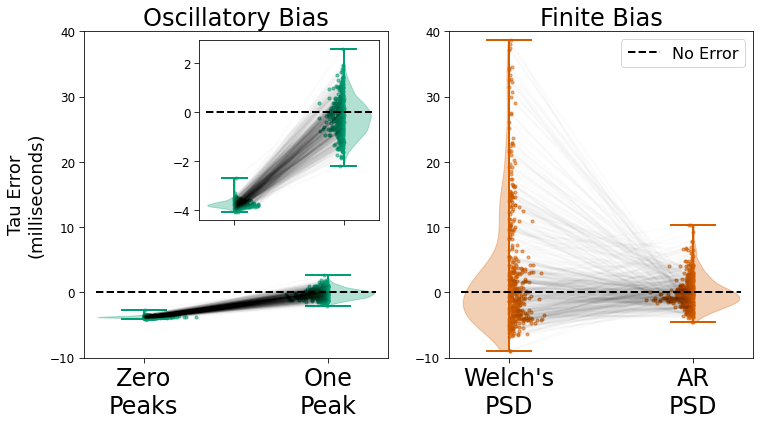

In [6]:
#plot_scatter(taus_zero_peak, taus_one_peak, taus_finite_welch,  taus_finite_ar,
#             dash=tau_ms, dash_label='Ground Truth', ylims=[[0, 50], [0, 50]])

plot_scatter(tau_error_zero_peak, tau_error_one_peak, tau_error_finite_welch, tau_error_finite_ar,
             ylims=[(-10, 40), (-10, 40)], dash=0, dash_label='No Error', ylabel='Tau Error\n(milliseconds)',
             save=True)

In [7]:
print('Taus')
print('----')
print('Finite Bias')
print(f'Welch: m={taus_finite_welch.mean().round(3)}, sd={taus_finite_welch.std().round(3)}')
print(f'AR   : m={taus_finite_ar.mean().round(3)}, sd={taus_finite_ar.std().round(3)}')
print()
print('Oscillatory Bias')
print(f'0 Peak: m={taus_zero_peak.mean().round(3)}, sd={taus_zero_peak.std().round(3)}')
print(f'1 Peak: m={taus_one_peak.mean().round(3)}, sd={taus_one_peak.std().round(3)}')
print()

print('Error')
print('-----')
print('Finite Bias')
print(f'Welch: m={tau_error_finite_welch.mean().round(3)}, sd={tau_error_finite_welch.std().round(3)}')
print(f'AR   : m={tau_error_finite_ar.mean().round(3)}, sd={tau_error_finite_ar.std().round(3)}')
print()
print('Oscillatory Bias')
print(f'0 Peak: m={tau_error_zero_peak.mean().round(3)}, sd={tau_error_zero_peak.std().round(3)}')
print(f'1 Peak: m={tau_error_one_peak.mean().round(3)}, sd={tau_error_one_peak.std().round(3)}')
print()
print(f'Finite     : {ttest_rel(tau_error_finite_welch, tau_error_finite_ar)}')
print(f'Oscillatory: {ttest_rel(tau_error_zero_peak, tau_error_one_peak)}')

Taus
----
Finite Bias
Welch: m=32.552, sd=47.644
AR   : m=9.99, sd=2.338

Oscillatory Bias
0 Peak: m=6.236, sd=0.128
1 Peak: m=9.803, sd=0.749

Error
-----
Finite Bias
Welch: m=22.552, sd=47.644
AR   : m=-0.01, sd=2.338

Oscillatory Bias
0 Peak: m=-3.764, sd=0.128
1 Peak: m=-0.197, sd=0.749

Finite     : Ttest_relResult(statistic=10.572685653633778, pvalue=1.0355491253750546e-23)
Oscillatory: Ttest_relResult(statistic=-114.54423145256351, pvalue=0.0)
